In [45]:
import yfinance as yf
import pandas as pd
from typing import Optional, Dict, Any, List
from datetime import date

class DataFetcher:
    """Fetch and process financial data from Yahoo Finance"""
    
    # Constants for column names
    EPS_COLUMNS = ["Basic EPS", "Diluted EPS", "Earnings Per Share"]
    BALANCE_SHEET_ITEMS = [
        'Total Assets', 
        'Total Liabilities Net Minority Interest', 
        'Total Equity Gross Minority Interest', 
        'Current Assets', 
        'Current Liabilities'
    ]
    CASH_FLOW_ITEMS = [
        'Operating Cash Flow', 
        'Investing Cash Flow', 
        'Financing Cash Flow', 
        'Free Cash Flow'
    ]
    
    def __init__(self, ticker_symbol: str):
        self.ticker_symbol = ticker_symbol.upper()
        self.ticker = yf.Ticker(ticker_symbol)
    
    def get_info(self) -> Dict[str, Any]:
        """Get basic company information"""
        try:
            return self.ticker.info
        except Exception as e:
            raise ValueError(f"Failed to fetch info for {self.ticker_symbol}: {e}")
        
    def get_income_statement(self) -> pd.DataFrame:
        """Get income statement data"""
        try:
            return self.ticker.income_stmt
        except Exception as e:
            raise ValueError(f"Failed to fetch income statement for {self.ticker_symbol}: {e}")

    def get_balance_sheet(self) -> pd.DataFrame:
        """Get balance sheet data"""
        try:
            return self.ticker.balance_sheet
        except Exception as e:
            raise ValueError(f"Failed to fetch balance sheet for {self.ticker_symbol}: {e}")

    def get_cash_flow(self) -> pd.DataFrame:
        """Get cash flow statement data"""
        try:
            return self.ticker.cashflow
        except Exception as e:
            raise ValueError(f"Failed to fetch cash flow for {self.ticker_symbol}: {e}")

    def get_share_price_data(self, period: str = "max") -> pd.DataFrame:
        """Get historical share price data"""
        try:
            share_price_data = self.ticker.history(period=period)
            if share_price_data.empty:
                raise ValueError(f"No share price data available for {self.ticker_symbol}")
            share_price_data.reset_index(inplace=True)
            return share_price_data
        except Exception as e:
            raise ValueError(f"Failed to fetch share price data for {self.ticker_symbol}: {e}")
    
    def get_dividends(self) -> pd.Series:
        """Get dividend data"""
        try:
            return self.ticker.dividends
        except Exception as e:
            raise ValueError(f"Failed to fetch dividends for {self.ticker_symbol}: {e}")
    
    def get_summary(self) -> Dict[str, Any]:
        """Get a summary of key metrics"""
        info = self.get_info()
        summary = {
            'company_name': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            'market_cap': info.get('marketCap'),
            'current_price': info.get('currentPrice'),
            'pe_ratio': info.get('trailingPE'),
            'eps': info.get('trailingEps'),
            'dividend_yield': info.get('dividendYield')
        }
        return summary
    
    def calculate_pe_ratio(self, price: Optional[float], earnings_per_share: Optional[float]) -> Optional[float]:
        """Calculate P/E ratio"""
        if not price or not earnings_per_share or earnings_per_share == 0:
            return None
        return price / earnings_per_share

    def get_comprehensive_data(self) -> pd.DataFrame:
        """
        Get all financial data and combine into a comprehensive DataFrame
        
        Returns:
            pandas.DataFrame: Combined data from all sources
            
        Raises:
            ValueError: If critical data cannot be fetched
        """
        # Get financial statements
        income_stmt = self.get_income_statement()
        balance_sheet = self.get_balance_sheet()
        cash_flow = self.get_cash_flow()
        
        # Get market data
        share_price_data = self.get_share_price_data()
        dividends = self.get_dividends()
        summary = self.get_summary()
        
        # Create enhanced income statement with additional metrics
        enhanced_income_stmt = self._create_enhanced_income_statement(
            income_stmt, share_price_data, dividends
        )
        
        # Combine everything into a master DataFrame
        combined_df = self._create_combined_dataframe(
            enhanced_income_stmt, balance_sheet, cash_flow, summary
        )
        
        return combined_df
    
    def _create_enhanced_income_statement(
        self, 
        income_stmt: pd.DataFrame, 
        share_price_data: pd.DataFrame, 
        dividends: pd.Series
    ) -> pd.DataFrame:
        """Create enhanced income statement with share price, dividends, and P/E ratio"""
        enhanced_is = income_stmt.copy()
        
        # Add ticker symbol
        enhanced_is.loc['Ticker'] = [self.ticker_symbol] * len(enhanced_is.columns)
        
        # Add share prices
        share_prices = self._get_share_prices_for_dates(enhanced_is.columns, share_price_data)
        enhanced_is.loc['Share Price'] = share_prices
        
        # Add total annual dividends
        dividend_values = self._get_annual_dividends_for_dates(enhanced_is.columns, dividends)
        enhanced_is.loc['Annual Dividends'] = dividend_values
        
        # Add P/E ratios
        pe_ratios = self._calculate_pe_ratios(enhanced_is)
        enhanced_is.loc["P/E Ratio"] = pe_ratios
        
        return enhanced_is
    
    def _get_share_prices_for_dates(
        self, 
        fiscal_dates: pd.Index, 
        share_price_data: pd.DataFrame
    ) -> List[Optional[float]]:
        """Get share prices for each fiscal date"""
        share_prices = []
        for date_str in fiscal_dates:
            fiscal_date = pd.to_datetime(date_str).date()
            mask = share_price_data['Date'].dt.date <= fiscal_date
            if mask.any():
                last_row = share_price_data[mask].iloc[-1]
                share_prices.append(last_row['Close'])
            else:
                share_prices.append(None)
        return share_prices
    
    def _get_annual_dividends_for_dates(
        self, 
        fiscal_dates: pd.Index, 
        dividends: pd.Series
    ) -> List[float]:
        """Calculate total annual dividends for each fiscal year"""
        dividend_values = []
        
        if dividends is None or dividends.empty:
            return [0.0] * len(fiscal_dates)
        
        dividends_df = dividends.reset_index()
        dividends_df['Date'] = pd.to_datetime(dividends_df['Date']).dt.tz_localize(None)
        
        for date_str in fiscal_dates:
            fiscal_date = pd.to_datetime(date_str).tz_localize(None)
            # Sum dividends in the year prior to fiscal date
            year_start = fiscal_date - pd.DateOffset(years=1)
            mask = (dividends_df['Date'] > year_start) & (dividends_df['Date'] <= fiscal_date)
            annual_div = dividends_df[mask]['Dividends'].sum() if mask.any() else 0.0
            dividend_values.append(annual_div)
        
        return dividend_values
    
    def _calculate_pe_ratios(self, enhanced_is: pd.DataFrame) -> List[Optional[float]]:
        """Calculate P/E ratios for each period"""
        pe_ratios = []
        for col in enhanced_is.columns:
            share_price = enhanced_is.loc["Share Price", col]
            
            # Try to find EPS from available columns
            eps = None
            for eps_name in self.EPS_COLUMNS:
                if eps_name in enhanced_is.index:
                    eps = enhanced_is.loc[eps_name, col]
                    break
            
            pe = self.calculate_pe_ratio(share_price, eps)
            pe_ratios.append(pe)
        
        return pe_ratios
    
    def _create_combined_dataframe(
        self, 
        enhanced_income_stmt: pd.DataFrame, 
        balance_sheet: pd.DataFrame, 
        cash_flow: pd.DataFrame, 
        summary: Dict[str, Any]
    ) -> pd.DataFrame:
        """Combine all data into a single DataFrame"""
        combined_df = enhanced_income_stmt.copy()
        
        # Add key balance sheet items
        for item in self.BALANCE_SHEET_ITEMS:
            if item in balance_sheet.index:
                combined_df.loc[item] = balance_sheet.loc[item]
        
        # Add key cash flow items
        for item in self.CASH_FLOW_ITEMS:
            if item in cash_flow.index:
                combined_df.loc[item] = cash_flow.loc[item]
        
        # Add summary metrics as new rows (only if values exist)
        num_cols = len(combined_df.columns)
        if summary['market_cap']:
            combined_df.loc['Market Cap'] = [summary['market_cap']] * num_cols
        if summary['current_price']:
            combined_df.loc['Current Price'] = [summary['current_price']] * num_cols
        if summary['sector']:
            combined_df.loc['Sector'] = [summary['sector']] * num_cols
        if summary['industry']:
            combined_df.loc['Industry'] = [summary['industry']] * num_cols
        
        return combined_df
    
    def display_data_overview(self, combined_df: pd.DataFrame) -> None:
        """Display an overview of fetched data"""
        summary = self.get_summary()
        
        print(f"\n{'='*50}")
        print(f"DATA OVERVIEW FOR {self.ticker_symbol}")
        print(f"{'='*50}")
        
        print(f"Company: {summary['company_name']}")
        print(f"Sector: {summary['sector']}")
        print(f"Industry: {summary['industry']}")
        
        if summary['market_cap']:
            print(f"Market Cap: ${summary['market_cap']:,.0f}")
        if summary['current_price']:
            print(f"Current Price: ${summary['current_price']:.2f}")
        if summary['pe_ratio']:
            print(f"P/E Ratio: {summary['pe_ratio']:.2f}")
        
        print(f"\nCombined DataFrame shape: {combined_df.shape}")
        print(f"Time periods covered: {len(combined_df.columns)}")


# Example usage
if __name__ == "__main__":
    try:
        # Create fetcher instance
        fetcher = DataFetcher("MSFT")
        
        # Get all data in one comprehensive DataFrame
        comprehensive_df = fetcher.get_comprehensive_data()
        
        # Display overview
        fetcher.display_data_overview(comprehensive_df)
        
        # Show sample of combined data
        print("\nFirst few rows of combined data:")
        print(comprehensive_df.head(10))
        
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")


DATA OVERVIEW FOR MSFT
Company: Microsoft Corporation
Sector: Technology
Industry: Software - Infrastructure
Market Cap: $3,841,385,824,256
Current Price: $516.79
P/E Ratio: 37.89

Combined DataFrame shape: (64, 4)
Time periods covered: 4

First few rows of combined data:
                                                        2025-06-30  \
Tax Effect Of Unusual Items                            -77088000.0   
Tax Rate For Calcs                                           0.176   
Normalized EBITDA                                   160603000000.0   
Total Unusual Items                                   -438000000.0   
Total Unusual Items Excluding Goodwill                -438000000.0   
Net Income From Continuing Operation Net Minori...  101832000000.0   
Reconciled Depreciation                              34153000000.0   
Reconciled Cost Of Revenue                           87831000000.0   
EBITDA                                              160165000000.0   
EBIT                      

In [46]:
import pandas as pd
from typing import List, Optional


class IVSimplifier:
    """
    Transforms comprehensive financial data into a simplified version 
    for intrinsic value calculations.
    
    Responsibilities:
    - Transform column names to Year-based format
    - Reorganize rows with Date at the top
    - Filter to essential financial metrics for valuation
    - Remove columns with missing data
    """
    
    # Essential metrics for intrinsic value calculation
    ESSENTIAL_METRICS = [
        'Date',
        'Ticker',
        'Market Cap',
        'P/E Ratio',
        'Basic EPS',
        'Free Cash Flow',
        'Operating Cash Flow',
        'Investing Cash Flow',
        'Annual Dividends',
        'Net Income',
        'Diluted EPS',
        'Share Price',
        'Total Assets',
        'Total Liabilities Net Minority Interest',
        'Total Equity Gross Minority Interest',
        'Basic Average Shares',
        'Diluted Average Shares'
    ]
    
    def __init__(self, comprehensive_df: pd.DataFrame):
        """
        Initialize with the comprehensive DataFrame.
        
        Args:
            comprehensive_df: DataFrame containing comprehensive financial data
            
        Raises:
            ValueError: If comprehensive_df is empty or None
        """
        if comprehensive_df is None or comprehensive_df.empty:
            raise ValueError("comprehensive_df cannot be None or empty")
        
        self.comprehensive_df = comprehensive_df.copy()
        self.simplified_df: Optional[pd.DataFrame] = None
    
    def _transform_columns_to_years(self) -> 'IVSimplifier':
        """
        Transform column names to Year-based format (Year 1, Year 2, etc.)
        and add Date row with actual years.
        
        Returns:
            Self for method chaining
        """
        try:
            # Extract years from column names and add as Date row
            years = [pd.to_datetime(col).year for col in self.comprehensive_df.columns]
            self.comprehensive_df.loc["Date"] = years
            
            # Create new column names (Year 1, Year 2, etc.)
            # Year 1 is most recent, increasing numbers go back in time
            num_cols = len(self.comprehensive_df.columns)
            new_col_names = [f"Year {num_cols - i}" for i in range(num_cols)]
            self.comprehensive_df.columns = new_col_names
            
            # Reorder rows to put Date at the top
            other_rows = [idx for idx in self.comprehensive_df.index if idx != "Date"]
            self.comprehensive_df = self.comprehensive_df.loc[["Date"] + other_rows]
            
        except Exception as e:
            raise ValueError(f"Failed to transform columns to years: {e}")
        
        return self
    
    def _filter_essential_metrics(self) -> 'IVSimplifier':
        """
        Filter DataFrame to keep only essential metrics for intrinsic value calculation.
        
        Returns:
            Self for method chaining
        """
        # Keep only rows that exist in the DataFrame and are in our essential list
        existing_rows = [
            row for row in self.ESSENTIAL_METRICS 
            if row in self.comprehensive_df.index
        ]
        
        if not existing_rows:
            raise ValueError("No essential metrics found in the DataFrame")
        
        self.simplified_df = self.comprehensive_df.loc[existing_rows]
        
        return self
    
    def _remove_empty_columns(self) -> 'IVSimplifier':
        """
        Remove columns with any missing data to ensure data quality.
        
        Returns:
            Self for method chaining
        """
        if self.simplified_df is None:
            raise ValueError("simplified_df is None. Call _filter_essential_metrics first")
        
        initial_cols = len(self.simplified_df.columns)
        self.simplified_df = self.simplified_df.dropna(axis=1, how='any')
        final_cols = len(self.simplified_df.columns)
        
        if final_cols == 0:
            raise ValueError("All columns removed due to missing data")
        
        if final_cols < initial_cols:
            print(f"Info: Removed {initial_cols - final_cols} column(s) with missing data")
        
        return self
    
    def simplify(self) -> pd.DataFrame:
        """
        Execute the complete simplification pipeline.
        
        Returns:
            pd.DataFrame: Simplified DataFrame ready for intrinsic value analysis
            
        Raises:
            ValueError: If simplification fails at any step
        """
        try:
            (self._transform_columns_to_years()
                 ._filter_essential_metrics()
                 ._remove_empty_columns())
            
            return self.get_simplified_data()
            
        except Exception as e:
            raise ValueError(f"Simplification failed: {e}")
    
    def get_simplified_data(self) -> pd.DataFrame:
        """
        Get the final simplified DataFrame.
        
        Returns:
            pd.DataFrame: Simplified financial data for valuation
            
        Raises:
            ValueError: If simplified data is not available
        """
        if self.simplified_df is None:
            raise ValueError("No simplified data available. Call simplify() first.")
        return self.simplified_df.copy()
    
    def get_original_data(self) -> pd.DataFrame:
        """
        Get the original comprehensive DataFrame (with column transformations applied).
        
        Returns:
            pd.DataFrame: Original data with year-based columns
        """
        return self.comprehensive_df.copy()
    
    def display_summary(self) -> None:
        """Display a summary of the simplified data"""
        if self.simplified_df is None:
            print("No simplified data available. Call simplify() first.")
            return
        
        print(f"\n{'='*50}")
        print("SIMPLIFIED DATA SUMMARY")
        print(f"{'='*50}")
        print(f"Metrics included: {len(self.simplified_df)}")
        print(f"Years of data: {len(self.simplified_df.columns)}")
        
        if 'Date' in self.simplified_df.index:
            years = self.simplified_df.loc['Date'].values
            print(f"Year range: {int(min(years))} - {int(max(years))}")
        
        if 'Ticker' in self.simplified_df.index:
            ticker = self.simplified_df.loc['Ticker'].iloc[0]
            print(f"Ticker: {ticker}")
        
        print(f"\nMetrics available:")
        for metric in self.simplified_df.index:
            if metric not in ['Date', 'Ticker']:
                print(f"  - {metric}")




In [47]:
# Example usage
if __name__ == "__main__":
    # Assuming you have comprehensive_df from DataFetcher
    try:
        from core.Data_fetcher import DataFetcher
        
        fetcher = DataFetcher("AAPL")
        comprehensive_df = fetcher.get_comprehensive_data()
        
        # Simplify the data
        simplifier = IVSimplifier(comprehensive_df)
        simplified_df = simplifier.simplify()
        
        # Display summary
        simplifier.display_summary()
        
        print("\nSimplified DataFrame:")
        print(simplified_df)
        
    except ImportError:
        print("Note: Run this with your actual DataFetcher import path")
        print("Example: from your_module import DataFetcher")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

Note: Run this with your actual DataFetcher import path
Example: from your_module import DataFetcher


In [48]:


# With your existing MSFT data
simplifier = IVSimplifier(comprehensive_df)
simplified_df = simplifier.simplify()
simplifier.display_summary()


SIMPLIFIED DATA SUMMARY
Metrics included: 17
Years of data: 4
Year range: 2022 - 2025
Ticker: MSFT

Metrics available:
  - Market Cap
  - P/E Ratio
  - Basic EPS
  - Free Cash Flow
  - Operating Cash Flow
  - Investing Cash Flow
  - Annual Dividends
  - Net Income
  - Diluted EPS
  - Share Price
  - Total Assets
  - Total Liabilities Net Minority Interest
  - Total Equity Gross Minority Interest
  - Basic Average Shares
  - Diluted Average Shares


In [49]:
simplified_df.head()

,Year 4,Year 3,Year 2,Year 1
Date,2025,2024,2023,2022
Ticker,MSFT,MSFT,MSFT,MSFT
Market Cap,3841385824256,3841385824256,3841385824256,3841385824256
P/E Ratio,36.247712,37.337382,34.441922,25.779927
Basic EPS,13.7,11.86,9.72,9.7


In [50]:
import pandas as pd
from typing import Dict, Optional, Tuple
import warnings


class ValuationCalculator:
    """
    Calculates intrinsic value using multiple valuation models.
    
    Models included:
    - Discounted Cash Flow (DCF)
    - Dividend Discount Model (DDM) - Single and Multi-stage
    - P/E Multiplier Model
    - Asset-Based Valuation
    - Modern Graham Formula
    """
    
    # Default parameters
    DEFAULT_DISCOUNT_RATE = 0.10
    DEFAULT_TERMINAL_GROWTH = 0.025
    DEFAULT_PROJECTION_YEARS = 5
    DEFAULT_BOND_YIELD = 0.0521  # 5.21%
    
    def __init__(self, simplified_df: pd.DataFrame):
        """
        Initialize with simplified financial data.
        
        Args:
            simplified_df: DataFrame from IVSimplifier containing essential financial metrics
            
        Raises:
            ValueError: If simplified_df is empty or None
        """
        if simplified_df is None or simplified_df.empty:
            raise ValueError("simplified_df cannot be None or empty")
        
        self.df = simplified_df.copy()
        self.results: Dict[str, float] = {}
        self.current_price: Optional[float] = None
        
        # Try to get current price
        if "Share Price" in self.df.index:
            self.current_price = self.df.loc["Share Price"].iloc[0]
    
    def calculate_dcf(
        self, 
        discount_rate: float = DEFAULT_DISCOUNT_RATE, 
        terminal_growth_rate: float = DEFAULT_TERMINAL_GROWTH,
        projection_years: int = DEFAULT_PROJECTION_YEARS
    ) -> Optional[float]:
        """
        Calculate intrinsic value using Discounted Cash Flow model.
        
        Args:
            discount_rate: Required rate of return (default 10%)
            terminal_growth_rate: Perpetual growth rate (default 2.5%)
            projection_years: Years to project (default 5)
            
        Returns:
            Intrinsic value per share, or None if calculation fails
        """
        try:
            # Validate inputs
            if discount_rate <= terminal_growth_rate:
                warnings.warn("Discount rate must be greater than terminal growth rate")
                return None
            
            # Get Free Cash Flow data
            if "Free Cash Flow" not in self.df.index:
                warnings.warn("Free Cash Flow data not available")
                return None
            
            fcf_row = self.df.loc["Free Cash Flow"]
            fcf_latest = fcf_row.iloc[0]  # Most recent (Year 1)
            fcf_earliest = fcf_row.iloc[-1]  # Oldest year
            n_years = len(fcf_row) - 1
            
            # Validate FCF data
            if fcf_earliest <= 0 or fcf_latest <= 0:
                warnings.warn("Cannot calculate DCF: negative or zero FCF")
                return None
            
            # Calculate historical CAGR
            cagr = (fcf_latest / fcf_earliest) ** (1 / n_years) - 1
            
            # Project future FCFs and calculate present values
            present_value_fcf = []
            
            for year in range(1, projection_years + 1):
                projected_fcf = fcf_latest * (1 + cagr) ** year
                pv_fcf = projected_fcf / (1 + discount_rate) ** year
                present_value_fcf.append(pv_fcf)
            
            # Calculate terminal value
            final_fcf = fcf_latest * (1 + cagr) ** projection_years
            terminal_value = (final_fcf * (1 + terminal_growth_rate) / 
                            (discount_rate - terminal_growth_rate))
            pv_terminal = terminal_value / (1 + discount_rate) ** projection_years
            
            # Calculate enterprise value
            total_pv_fcf = sum(present_value_fcf)
            enterprise_value = total_pv_fcf + pv_terminal
            
            # Convert to per-share value
            shares_outstanding = self._get_shares_outstanding()
            if shares_outstanding is None or shares_outstanding <= 0:
                warnings.warn("Invalid shares outstanding data")
                return None
            
            value_per_share = enterprise_value / shares_outstanding
            
            self.results['dcf'] = value_per_share
            return value_per_share
            
        except (KeyError, IndexError, ZeroDivisionError) as e:
            warnings.warn(f"DCF calculation failed: {e}")
            return None
    
    def calculate_ddm(
        self, 
        required_rate: float = DEFAULT_DISCOUNT_RATE, 
        terminal_growth: float = DEFAULT_TERMINAL_GROWTH,
        projection_years: int = DEFAULT_PROJECTION_YEARS
    ) -> Optional[float]:
        """
        Calculate intrinsic value using Dividend Discount Model (multi-stage).
        
        Args:
            required_rate: Required rate of return (default 10%)
            terminal_growth: Terminal growth rate (default 2.5%)
            projection_years: Years to project (default 5)
            
        Returns:
            Intrinsic value per share, or None if calculation fails
        """
        try:
            # Validate inputs
            if required_rate <= terminal_growth:
                warnings.warn("Required rate must be greater than terminal growth")
                return None
            
            # Get dividend data
            if "Annual Dividends" not in self.df.index:
                warnings.warn("Dividend data not available")
                return None
            
            dividends_row = self.df.loc["Annual Dividends"]
            
            # Check if company pays dividends
            if dividends_row.sum() == 0:
                warnings.warn("Company does not pay dividends")
                return None
            
            div_latest = dividends_row.iloc[0]  # Most recent
            div_earliest = dividends_row.iloc[-1]  # Oldest
            n_years = len(dividends_row) - 1
            
            if div_earliest <= 0 or div_latest <= 0:
                warnings.warn("Cannot calculate DDM: negative or zero dividends")
                return None
            
            # Calculate dividend growth rate
            growth_rate = (div_latest / div_earliest) ** (1 / n_years) - 1
            
            # Single-stage Gordon Growth Model
            dividend_next_year = div_latest * (1 + growth_rate)
            single_stage_value = dividend_next_year / (required_rate - growth_rate)
            
            # Multi-stage DDM
            pv_dividends = 0
            for t in range(1, projection_years + 1):
                div_projected = div_latest * (1 + growth_rate) ** t
                pv_dividends += div_projected / (1 + required_rate) ** t
            
            # Terminal value
            terminal_dividend = div_latest * (1 + growth_rate) ** projection_years * (1 + terminal_growth)
            pv_terminal = (terminal_dividend / (required_rate - terminal_growth)) / (1 + required_rate) ** projection_years
            
            multi_stage_value = pv_dividends + pv_terminal
            
            self.results['ddm_single_stage'] = single_stage_value
            self.results['ddm_multi_stage'] = multi_stage_value
            return multi_stage_value
            
        except (KeyError, IndexError, ZeroDivisionError) as e:
            warnings.warn(f"DDM calculation failed: {e}")
            return None
    
    def calculate_pe_model(self) -> Optional[float]:
        """
        Calculate intrinsic value using P/E Multiplier model.
        Uses average historical P/E ratio multiplied by current EPS.
        
        Returns:
            Intrinsic value per share, or None if calculation fails
        """
        try:
            # Get EPS data
            eps = self._get_eps()
            if eps is None or eps <= 0:
                warnings.warn("Invalid EPS data for P/E model")
                return None
            
            # Get historical P/E ratios
            if "P/E Ratio" not in self.df.index:
                warnings.warn("P/E Ratio data not available")
                return None
            
            pe_row = self.df.loc["P/E Ratio"].dropna()
            
            if len(pe_row) == 0:
                warnings.warn("No valid P/E ratios available")
                return None
            
            expected_pe = pe_row.mean()
            
            value = eps * expected_pe
            self.results['pe_model'] = value
            return value
            
        except (KeyError, IndexError) as e:
            warnings.warn(f"P/E Model calculation failed: {e}")
            return None
    
    def calculate_asset_based(self) -> Optional[float]:
        """
        Calculate intrinsic value using Asset-Based valuation (Book Value).
        
        Returns:
            Book value per share, or None if calculation fails
        """
        try:
            # Get balance sheet data
            if "Total Assets" not in self.df.index:
                warnings.warn("Total Assets data not available")
                return None
            
            if "Total Liabilities Net Minority Interest" not in self.df.index:
                warnings.warn("Total Liabilities data not available")
                return None
            
            total_assets = self.df.loc["Total Assets"].iloc[0]
            total_liabilities = self.df.loc["Total Liabilities Net Minority Interest"].iloc[0]
            shares_outstanding = self._get_shares_outstanding()
            
            if shares_outstanding is None or shares_outstanding <= 0:
                warnings.warn("Invalid shares outstanding data")
                return None
            
            book_value_per_share = (total_assets - total_liabilities) / shares_outstanding
            self.results['asset_based'] = book_value_per_share
            return book_value_per_share
            
        except (KeyError, IndexError, ZeroDivisionError) as e:
            warnings.warn(f"Asset-Based valuation failed: {e}")
            return None
    
    def calculate_graham_value(self, bond_yield: float = DEFAULT_BOND_YIELD) -> Optional[float]:
        """
        Calculate intrinsic value using Modern Graham Formula.
        Formula: V = EPS × (8.5 + 2g) × (4.4 / Y)
        
        Args:
            bond_yield: Corporate bond yield (default 5.21%)
            
        Returns:
            Graham value per share, or None if calculation fails
        """
        try:
            # Get EPS data
            eps = self._get_eps()
            if eps is None or eps <= 0:
                warnings.warn("Invalid EPS data for Graham formula")
                return None
            
            # Calculate EPS growth rate
            if "Diluted EPS" not in self.df.index:
                warnings.warn("EPS data not available for growth calculation")
                return None
            
            eps_row = self.df.loc["Diluted EPS"].dropna()
            if len(eps_row) < 2:
                warnings.warn("Insufficient EPS history for growth calculation")
                return None
            
            eps_latest = eps_row.iloc[0]
            eps_earliest = eps_row.iloc[-1]
            n_years = len(eps_row) - 1
            
            if eps_earliest <= 0:
                warnings.warn("Cannot calculate growth: negative or zero historical EPS")
                return None
            
            # Calculate growth rate in percentage
            growth_rate = ((eps_latest / eps_earliest) ** (1 / n_years) - 1) * 100
            
            # Apply Graham Formula
            value = eps * (8.5 + 2 * growth_rate) * (4.4 / (bond_yield * 100))
            
            self.results['graham_value'] = value
            return value
            
        except (KeyError, IndexError, ZeroDivisionError) as e:
            warnings.warn(f"Graham Value calculation failed: {e}")
            return None
    
    def calculate_all_valuations(self, **kwargs) -> Dict[str, float]:
        """
        Calculate all valuation models and return results.
        
        Args:
            **kwargs: Optional parameters to pass to individual models
            
        Returns:
            Dictionary containing all successful valuation results
        """
        self.calculate_dcf(**kwargs)
        self.calculate_ddm(**kwargs)
        self.calculate_pe_model()
        self.calculate_asset_based()
        self.calculate_graham_value(**kwargs)
        
        return self.get_results()
    
    def get_results(self) -> Dict[str, float]:
        """Get all calculated valuation results."""
        return self.results.copy()
    
    def get_average_valuation(self) -> Optional[float]:
        """
        Calculate average of all valuation models.
        
        Returns:
            Average intrinsic value, or None if no valuations available
        """
        if not self.results:
            return None
        return sum(self.results.values()) / len(self.results)
    
    def get_margin_of_safety(self, target_margin: float = 0.25) -> Optional[Dict[str, any]]:
        """
        Calculate margin of safety for each valuation method.
        
        Args:
            target_margin: Desired margin of safety (default 25%)
            
        Returns:
            Dictionary with margin of safety analysis
        """
        if self.current_price is None:
            warnings.warn("Current price not available")
            return None
        
        if not self.results:
            warnings.warn("No valuation results available")
            return None
        
        analysis = {}
        for model, intrinsic_value in self.results.items():
            margin = (intrinsic_value - self.current_price) / intrinsic_value
            buy_price = intrinsic_value * (1 - target_margin)
            
            analysis[model] = {
                'intrinsic_value': intrinsic_value,
                'current_price': self.current_price,
                'margin_of_safety': margin,
                'is_undervalued': margin >= target_margin,
                'target_buy_price': buy_price
            }
        
        return analysis
    
    def print_results(self, show_margin_of_safety: bool = True):
        """
        Print all valuation results in a formatted way.
        
        Args:
            show_margin_of_safety: Whether to show margin of safety analysis
        """
        print("\n" + "="*60)
        print("INTRINSIC VALUATION RESULTS")
        print("="*60)
        
        if not self.results:
            print("No valuation results available")
            return
        
        models = {
            'dcf': 'DCF Intrinsic Value per Share',
            'ddm_single_stage': 'DDM Single-Stage Value per Share', 
            'ddm_multi_stage': 'DDM Multi-Stage Value per Share',
            'pe_model': 'P/E Model Intrinsic Value',
            'asset_based': 'Asset-Based Value per Share',
            'graham_value': 'Modern Graham Value per Share'
        }
        
        for key, description in models.items():
            if key in self.results:
                value = self.results[key]
                print(f"{description:.<50} ${value:,.2f}")
        
        avg_value = self.get_average_valuation()
        if avg_value:
            print(f"\n{'Average Intrinsic Value':.<50} ${avg_value:,.2f}")
        
        if self.current_price:
            print(f"{'Current Market Price':.<50} ${self.current_price:,.2f}")
        
        # Margin of safety analysis
        if show_margin_of_safety and self.current_price:
            print("\n" + "="*60)
            print("MARGIN OF SAFETY ANALYSIS")
            print("="*60)
            
            margin_analysis = self.get_margin_of_safety()
            if margin_analysis:
                for model, data in margin_analysis.items():
                    model_name = models.get(model, model)
                    margin_pct = data['margin_of_safety'] * 100
                    status = "✓ UNDERVALUED" if data['is_undervalued'] else "✗ OVERVALUED"
                    
                    print(f"\n{model_name}:")
                    print(f"  Margin of Safety: {margin_pct:+.1f}% {status}")
                    print(f"  Target Buy Price (25% margin): ${data['target_buy_price']:,.2f}")
        
        print("="*60)
    
    def _get_eps(self) -> Optional[float]:
        """Helper method to get the most recent EPS (prefer Diluted over Basic)"""
        if "Diluted EPS" in self.df.index:
            return self.df.loc["Diluted EPS"].iloc[0]
        elif "Basic EPS" in self.df.index:
            return self.df.loc["Basic EPS"].iloc[0]
        return None
    
    def _get_shares_outstanding(self) -> Optional[float]:
        """Helper method to get shares outstanding (prefer Basic over Diluted)"""
        if "Basic Average Shares" in self.df.index:
            return self.df.loc["Basic Average Shares"].iloc[0]
        elif "Diluted Average Shares" in self.df.index:
            return self.df.loc["Diluted Average Shares"].iloc[0]
        return None




In [51]:
# Example usage
if __name__ == "__main__":
    
    try:
        # Fetch data
        fetcher = DataFetcher("AAPL")
        comprehensive_df = fetcher.get_comprehensive_data()
        
        # Simplify data
        simplifier = IVSimplifier(comprehensive_df)
        simplified_df = simplifier.simplify()
        
        # Calculate valuations
        calculator = ValuationCalculator(simplified_df)
        calculator.calculate_all_valuations()
        
        # Display results
        calculator.print_results()
        
    except Exception as e:
        print(f"Error: {e}")


INTRINSIC VALUATION RESULTS
DCF Intrinsic Value per Share..................... $109.48
DDM Single-Stage Value per Share.................. $19.99
DDM Multi-Stage Value per Share................... $14.80
P/E Model Intrinsic Value......................... $170.29
Asset-Based Value per Share....................... $3.71
Modern Graham Value per Share..................... $71.56

Average Intrinsic Value........................... $64.97
Current Market Price.............................. $231.92

MARGIN OF SAFETY ANALYSIS

DCF Intrinsic Value per Share:
  Margin of Safety: -111.8% ✗ OVERVALUED
  Target Buy Price (25% margin): $82.11

DDM Single-Stage Value per Share:
  Margin of Safety: -1060.4% ✗ OVERVALUED
  Target Buy Price (25% margin): $14.99

DDM Multi-Stage Value per Share:
  Margin of Safety: -1467.4% ✗ OVERVALUED
  Target Buy Price (25% margin): $11.10

P/E Model Intrinsic Value:
  Margin of Safety: -36.2% ✗ OVERVALUED
  Target Buy Price (25% margin): $127.72

Asset-Based Value per

In [108]:
import pandas as pd
from typing import List, Dict, Optional
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed


class MultiCompanyAggregator:
    """
    Aggregates simplified financial data from multiple companies for sector analysis.
    
    Responsibilities:
    - Fetch and simplify data for multiple tickers
    - Combine into a single comparative DataFrame
    - Group by sector for analysis
    - Prepare data for visualization
    """
    
    def __init__(self, data_fetcher_class, simplifier_class):
        """
        Initialize with the DataFetcher and IVSimplifier classes.
        
        Args:
            data_fetcher_class: DataFetcher class (not instance)
            simplifier_class: IVSimplifier class (not instance)
        """
        self.data_fetcher_class = data_fetcher_class
        self.simplifier_class = simplifier_class
        self.company_data: Dict[str, pd.DataFrame] = {}
        self.sector_info: Dict[str, Dict[str, str]] = {}
        self.combined_df: Optional[pd.DataFrame] = None
    
    def fetch_company_data(self, ticker: str) -> Optional[pd.DataFrame]:
        """
        Fetch and simplify data for a single company.
        
        Args:
            ticker: Stock ticker symbol
            
        Returns:
            Simplified DataFrame or None if fetch fails
        """
        try:
            # Fetch comprehensive data
            fetcher = self.data_fetcher_class(ticker)
            comprehensive_df = fetcher.get_comprehensive_data()
            
            # Get sector info
            summary = fetcher.get_summary()
            self.sector_info[ticker] = {
                'company_name': summary.get('company_name', 'N/A'),
                'sector': summary.get('sector', 'N/A'),
                'industry': summary.get('industry', 'N/A')
            }
            
            # Simplify data
            simplifier = self.simplifier_class(comprehensive_df)
            simplified_df = simplifier.simplify()
            
            return simplified_df
            
        except Exception as e:
            warnings.warn(f"Failed to fetch data for {ticker}: {e}")
            return None
    
    def fetch_multiple_companies(
        self, 
        tickers: List[str], 
        parallel: bool = True,
        max_workers: int = 5
    ) -> Dict[str, pd.DataFrame]:
        """
        Fetch data for multiple companies.
        
        Args:
            tickers: List of stock ticker symbols
            parallel: Whether to fetch in parallel (default True)
            max_workers: Number of parallel workers (default 5)
            
        Returns:
            Dictionary mapping tickers to their simplified DataFrames
        """
        if parallel:
            return self._fetch_parallel(tickers, max_workers)
        else:
            return self._fetch_sequential(tickers)
    
    def _fetch_sequential(self, tickers: List[str]) -> Dict[str, pd.DataFrame]:
        """Fetch companies sequentially"""
        results = {}
        
        for ticker in tickers:
            print(f"Fetching {ticker}...")
            df = self.fetch_company_data(ticker)
            if df is not None:
                results[ticker] = df
                self.company_data[ticker] = df
        
        return results
    
    def _fetch_parallel(self, tickers: List[str], max_workers: int) -> Dict[str, pd.DataFrame]:
        """Fetch companies in parallel"""
        results = {}
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_ticker = {
                executor.submit(self.fetch_company_data, ticker): ticker 
                for ticker in tickers
            }
            
            for future in as_completed(future_to_ticker):
                ticker = future_to_ticker[future]
                try:
                    df = future.result()
                    if df is not None:
                        results[ticker] = df
                        self.company_data[ticker] = df
                        print(f"✓ Fetched {ticker}")
                    else:
                        print(f"✗ Failed {ticker}")
                except Exception as e:
                    warnings.warn(f"Error fetching {ticker}: {e}")
        
        return results
    
    def create_combined_dataframe(
        self, 
        metrics: Optional[List[str]] = None,
        latest_year_only: bool = True
    ) -> pd.DataFrame:
        """
        Combine all company data into a single DataFrame for comparison.
        
        Args:
            metrics: List of metrics to include (None = all common metrics)
            latest_year_only: If True, only include most recent year (default)
            
        Returns:
            Combined DataFrame with all companies
        """
        if not self.company_data:
            raise ValueError("No company data available. Call fetch_multiple_companies first.")
        
        combined_data = []
        
        for ticker, df in self.company_data.items():
            # Get company info
            company_info = self.sector_info.get(ticker, {})
            
            if latest_year_only:
                # Extract only Year 1 (most recent) data
                year_col = 'Year 1' if 'Year 1' in df.columns else df.columns[0]
                company_row = {
                    'Ticker': ticker,
                    'Company': company_info.get('company_name', ticker),
                    'Sector': company_info.get('sector', 'Unknown'),
                    'Industry': company_info.get('industry', 'Unknown')
                }
                
                # Add metrics
                if metrics:
                    for metric in metrics:
                        if metric in df.index:
                            company_row[metric] = df.loc[metric, year_col]
                else:
                    # Add all metrics except Date and Ticker
                    for metric in df.index:
                        if metric not in ['Date', 'Ticker']:
                            company_row[metric] = df.loc[metric, year_col]
                
                combined_data.append(company_row)
            else:
                # Include all years (creates multiple rows per company)
                for col in df.columns:
                    year = df.loc['Date', col] if 'Date' in df.index else col
                    company_row = {
                        'Ticker': ticker,
                        'Company': company_info.get('company_name', ticker),
                        'Sector': company_info.get('sector', 'Unknown'),
                        'Industry': company_info.get('industry', 'Unknown'),
                        'Year': year
                    }
                    
                    # Add metrics
                    if metrics:
                        for metric in metrics:
                            if metric in df.index:
                                company_row[metric] = df.loc[metric, col]
                    else:
                        for metric in df.index:
                            if metric not in ['Date', 'Ticker']:
                                company_row[metric] = df.loc[metric, col]
                    
                    combined_data.append(company_row)
        
        self.combined_df = pd.DataFrame(combined_data)
        return self.combined_df
    
    def get_sector_summary(self, metric: str) -> pd.DataFrame:
        """
        Get summary statistics for a metric grouped by sector.
        
        Args:
            metric: The financial metric to analyze
            
        Returns:
            DataFrame with sector-level statistics
        """
        if self.combined_df is None:
            raise ValueError("No combined data available. Call create_combined_dataframe first.")
        
        if metric not in self.combined_df.columns:
            raise ValueError(f"Metric '{metric}' not found in combined data")
        
        # Group by sector and calculate statistics
        sector_stats = self.combined_df.groupby('Sector')[metric].agg([
            ('count', 'count'),
            ('mean', 'mean'),
            ('median', 'median'),
            ('std', 'std'),
            ('min', 'min'),
            ('max', 'max')
        ]).round(2)
        
        return sector_stats
    
    def get_sector_data(self, sector: str) -> pd.DataFrame:
        """
        Get all companies in a specific sector.
        
        Args:
            sector: Sector name
            
        Returns:
            DataFrame filtered to the specified sector
        """
        if self.combined_df is None:
            raise ValueError("No combined data available. Call create_combined_dataframe first.")
        
        return self.combined_df[self.combined_df['Sector'] == sector].copy()
    
    def get_top_companies(
        self, 
        metric: str, 
        n: int = 10, 
        ascending: bool = False
    ) -> pd.DataFrame:
        """
        Get top N companies by a specific metric.
        
        Args:
            metric: Metric to sort by
            n: Number of companies to return
            ascending: Sort order (False = highest first)
            
        Returns:
            DataFrame with top companies
        """
        if self.combined_df is None:
            raise ValueError("No combined data available. Call create_combined_dataframe first.")
        
        if metric not in self.combined_df.columns:
            raise ValueError(f"Metric '{metric}' not found in combined data")
        
        return self.combined_df.nlargest(n, metric) if not ascending else self.combined_df.nsmallest(n, metric)
    
    def export_to_csv(self, filename: str) -> None:
        """
        Export combined data to CSV.
        
        Args:
            filename: Output CSV filename
        """
        if self.combined_df is None:
            raise ValueError("No combined data available. Call create_combined_dataframe first.")
        
        self.combined_df.to_csv(filename, index=False)
        print(f"Data exported to {filename}")
    
    def get_available_sectors(self) -> List[str]:
        """Get list of all sectors in the data"""
        if self.combined_df is None:
            raise ValueError("No combined data available. Call create_combined_dataframe first.")
        
        return sorted(self.combined_df['Sector'].unique().tolist())
    
    def display_summary(self) -> None:
        """Display a summary of the aggregated data"""
        print("\n" + "="*60)
        print("MULTI-COMPANY DATA SUMMARY")
        print("="*60)
        
        print(f"Total companies: {len(self.company_data)}")
        print(f"\nCompanies by ticker:")
        for ticker, info in self.sector_info.items():
            print(f"  {ticker}: {info['company_name']} ({info['sector']})")
        
        if self.combined_df is not None:
            print(f"\nCombined DataFrame shape: {self.combined_df.shape}")
            print(f"Sectors represented: {len(self.get_available_sectors())}")
            print(f"Sectors: {', '.join(self.get_available_sectors())}")
        
        print("="*60)


# Example usage
if __name__ == "__main__":
    
    # Define tickers to analyze
    tech_tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA']
    
    try:
        # Create aggregator
        aggregator = MultiCompanyAggregator(DataFetcher, IVSimplifier)
        
        # Fetch data for multiple companies
        print("Fetching data for multiple companies...")
        aggregator.fetch_multiple_companies(tech_tickers, parallel=True)
        
        # Create combined dataframe (latest year only)
        combined_df = aggregator.create_combined_dataframe(
            metrics=['Market Cap','Basic EPS', 'Free Cash Flow', 'P/E Ratio', 'Share Price'],
            latest_year_only=True
        )
        
        # Display summary
        aggregator.display_summary()
        
        print("\nCombined Data Preview:")
        print(combined_df)
        
        # Get sector summary for a specific metric
        print("\nP/E Ratio by Sector:")
        pe_summary = aggregator.get_sector_summary('P/E Ratio')
        print(pe_summary)
        
        # Export to CSV
        aggregator.export_to_csv('multi_company_analysis.csv')
        
    except Exception as e:
        print(f"Error: {e}")

Fetching data for multiple companies...
✓ Fetched NVDA
Info: Removed 1 column(s) with missing data
✓ Fetched META
✓ Fetched GOOGL
✓ Fetched MSFT
✓ Fetched AAPL

MULTI-COMPANY DATA SUMMARY
Total companies: 5

Companies by ticker:
  NVDA: NVIDIA Corporation (Technology)
  META: Meta Platforms, Inc. (Communication Services)
  GOOGL: Alphabet Inc. (Communication Services)
  MSFT: Microsoft Corporation (Technology)
  AAPL: Apple Inc. (Technology)

Combined DataFrame shape: (5, 9)
Sectors represented: 2
Sectors: Communication Services, Technology

Combined Data Preview:
  Ticker                Company                  Sector  \
0   NVDA     NVIDIA Corporation              Technology   
1   META   Meta Platforms, Inc.  Communication Services   
2  GOOGL          Alphabet Inc.  Communication Services   
3   MSFT  Microsoft Corporation              Technology   
4   AAPL             Apple Inc.              Technology   

                         Industry     Market Cap  Basic EPS  Free Cash Flo

In [109]:
combined_df


,Ticker,Company,Sector,Industry,Market Cap,Basic EPS,Free Cash Flow,P/E Ratio,Share Price
0,NVDA,NVIDIA Corporation,Technology,Semiconductors,4460857262080,0.391,8.132000e+09,62.506454,24.440023
1,META,"Meta Platforms, Inc.",Communication Services,Internet Content & Information,1800991932416,24.610,5.407200e+10,23.736106,584.145569
2,GOOGL,Alphabet Inc.,Communication Services,Internet Content & Information,3066071089152,5.694,6.701200e+10,25.265149,143.859756
3,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,3847852654592,9.700,6.514900e+10,25.779930,250.065323
4,AAPL,Apple Inc.,Technology,Consumer Electronics,3899609055232,5.670,9.295300e+10,24.431184,138.524811


In [53]:
df

,Ticker,Company,Sector,Industry,Year,Date,P/E Ratio,Basic EPS,Free Cash Flow,Operating Cash Flow,Investing Cash Flow,Annual Dividends,Net Income,Diluted EPS,Share Price,Total Assets,Total Liabilities Net Minority Interest,Total Equity Gross Minority Interest,Basic Average Shares,Diluted Average Shares
0,ACN,Accenture plc,Technology,Information Technology Services,2024,2024,29.020740,11.57,8.614518e+09,9.131027e+09,-7.061818e+09,5.160,7.264787e+09,11.44,335.769958,5.593236e+10,2.676412e+10,2.916825e+10,6.278526e+08,6.359400e+08
1,ACN,Accenture plc,Technology,Information Technology Services,2023,2023,28.703179,10.90,8.996096e+09,9.524268e+09,-2.622470e+09,4.480,6.871557e+09,10.77,312.864655,5.124530e+10,2.478671e+10,2.645859e+10,6.306082e+08,6.385916e+08
2,ACN,Accenture plc,Technology,Information Technology Services,2022,2022,25.234851,10.87,8.823131e+09,9.541129e+09,-4.260629e+09,3.880,6.877169e+09,10.71,274.302826,4.726339e+10,2.451630e+10,2.274709e+10,6.327627e+08,6.428392e+08
3,ACN,Accenture plc,Technology,Information Technology Services,2021,2021,33.963481,9.31,8.395016e+09,8.975148e+09,-4.309766e+09,3.520,5.906809e+09,9.16,316.200012,4.317584e+10,2.307873e+10,2.009711e+10,6.347451e+08,6.459090e+08
4,ADBE,Adobe Inc.,Technology,Software - Application,2024,2024,41.506838,12.43,7.873000e+09,8.056000e+09,1.490000e+08,0.000,5.560000e+09,12.36,515.929993,3.023000e+10,1.612500e+10,1.410500e+10,4.470000e+08,4.500000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,VLO,Valero Energy Corporation,Energy,Oil & Gas Refining & Marketing,2021,2021,29.313320,2.27,4.194000e+09,5.859000e+09,-2.159000e+09,3.920,9.300000e+08,2.27,66.541237,5.788800e+10,3.807100e+10,1.981700e+10,4.070000e+08,4.070000e+08
1178,WMB,"The Williams Companies, Inc.",Energy,Oil & Gas Midstream,2024,2024,28.980037,1.82,2.296000e+09,4.974000e+09,-4.863000e+09,1.900,2.225000e+09,1.82,52.743668,5.453200e+10,3.969200e+10,1.484000e+10,1.219184e+09,1.222954e+09
1179,WMB,"The Williams Companies, Inc.",Energy,Oil & Gas Midstream,2023,2023,12.447404,2.61,3.371000e+09,5.938000e+09,-3.891000e+09,1.792,3.179000e+09,2.60,32.487724,5.262700e+10,3.773600e+10,1.489100e+10,1.217784e+09,1.222715e+09
1180,WMB,"The Williams Companies, Inc.",Energy,Oil & Gas Midstream,2022,2022,17.287066,1.68,2.606000e+09,4.889000e+09,-3.375000e+09,1.700,2.049000e+09,1.67,29.042271,4.843300e+10,3.438800e+10,1.404500e+10,1.218362e+09,1.222672e+09


In [106]:
df['Industry'].unique()

array(['Information Technology Services', 'Electronic Components',
       'Software - Application', 'Software - Infrastructure',
       'Semiconductors', 'Advertising Agencies',
       'Semiconductor Equipment & Materials', 'Consumer Electronics',
       'Computer Hardware', 'Communication Equipment', 'Solar',
       'Scientific & Technical Instruments', 'Diagnostics & Research',
       'Drug Manufacturers - General', 'Medical Devices',
       'Medical Instruments & Supplies', 'Biotechnology',
       'Medical Distribution', 'Healthcare Plans',
       'Medical Care Facilities', 'Health Information Services',
       'Drug Manufacturers - Specialty & Generic', 'Insurance - Life',
       'Credit Services', 'Asset Management', 'Insurance Brokers',
       'Insurance - Diversified', 'Insurance - Property & Casualty',
       'Banks - Diversified', 'Capital Markets', 'Banks - Regional',
       'Financial Data & Stock Exchanges', 'Insurance - Reinsurance',
       'Specialty Business Services', '

In [54]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: Fetch the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
response = requests.get(url, headers=headers)
response.raise_for_status()

# Step 2: Parse HTML with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Step 3: Find the main table
table = soup.find("table", {"id": "constituents"})

# Step 4: Extract all rows
rows = table.find_all("tr")

# Step 5: Parse rows into structured data
data = []
for row in rows[1:]:  # skip the header
    cols = row.find_all("td")
    if len(cols) >= 8:
        symbol = cols[0].text.strip().replace(".", "-")  # Yahoo uses "-" instead of "."
        security = cols[1].text.strip()
        sector = cols[2].text.strip()
        sub_industry = cols[3].text.strip()
        headquarters = cols[4].text.strip()
        date_added = cols[5].text.strip()
        cik = cols[6].text.strip()
        founded = cols[7].text.strip()

        data.append({
            "Symbol": symbol,
            "Security": security,
            "GICS Sector": sector,
            "GICS Sub-Industry": sub_industry,
            "Headquarters": headquarters,
            "Date Added": date_added,
            "CIK": cik,
            "Founded": founded
        })

# Step 6: Convert to DataFrame
df = pd.DataFrame(data)

# Step 7: Group by GICS Sector and Sub-Industry
grouped = df.groupby("GICS Sector")["Symbol"].apply(list).reset_index()

# Step 8: Show or save the results
print(grouped.head())
# grouped.to_csv("sp500_by_sector_industry.csv", index=False)


              GICS Sector                                             Symbol
0  Communication Services  [GOOGL, GOOG, T, CHTR, CMCSA, EA, FOXA, FOX, I...
1  Consumer Discretionary  [ABNB, AMZN, APTV, AZO, BBY, BKNG, KMX, CCL, C...
2        Consumer Staples  [MO, ADM, BF-B, BG, CPB, CHD, CLX, KO, CL, CAG...
3                  Energy  [APA, BKR, CVX, COP, CTRA, DVN, FANG, EOG, EQT...
4              Financials  [AFL, ALL, AXP, AIG, AMP, AON, APO, ACGL, AJG,...


In [55]:
# Assuming 'grouped' is your grouped DataFrame
sector_dict = dict(zip(grouped["GICS Sector"], grouped["Symbol"]))

# Example: access sector tickers directly
tech_tickers = sector_dict["Information Technology"]
healthcare_tickers = sector_dict["Health Care"]
financials_tickers = sector_dict["Financials"]
communications_tickers = sector_dict["Communication Services"]
consumer_discretionary_tickers = sector_dict["Consumer Discretionary"]
energy_tickers = sector_dict["Energy"]
utilities_tickers = sector_dict["Utilities"]
consumer_staples_tickers = sector_dict["Consumer Staples"]
real_estate_tickers = sector_dict["Real Estate"]
industrials_tickers = sector_dict["Industrials"]
materials_tickers = sector_dict["Materials"]


In [92]:
aggregator = MultiCompanyAggregator(DataFetcher, IVSimplifier)

# Fetch tech stocks
aggregator.fetch_multiple_companies(
    tech_tickers + healthcare_tickers + financials_tickers + communications_tickers + energy_tickers + consumer_discretionary_tickers,)


# Combine into one DataFrame
df = aggregator.create_combined_dataframe(
    metrics=['Date',
        'Ticker',
        'Market Cap',
        'P/E Ratio',
        'Basic EPS',
        'Free Cash Flow',
        'Operating Cash Flow',
        'Investing Cash Flow',
        'Annual Dividends',
        'Net Income',
        'Diluted EPS',
        'Share Price',
        'Total Assets',
        'Total Liabilities Net Minority Interest',
        'Total Equity Gross Minority Interest',
        'Basic Average Shares',
        'Diluted Average Shares'
    ],
    latest_year_only=False  # Set to True for only the latest year
)

# Sector analysis
pe_by_sector = aggregator.get_sector_summary("P/E Ratio")
diluted_eps_by_sector = aggregator.get_sector_summary("Diluted EPS")
free_cash_flow_by_sector = aggregator.get_sector_summary("Free Cash Flow")
share_price_by_sector = aggregator.get_sector_summary("Share Price")
tech_companies = aggregator.get_sector_data("Technology")
healthcare_companies = aggregator.get_sector_data("Healthcare")
financials_companies = aggregator.get_sector_data("Financials")  # only works if you fetched financials tickers
communications_companies = aggregator.get_sector_data("Communication Services")
energy_companies = aggregator.get_sector_data("Energy")          # only works if you fetched energy tickers
consumer_discretionary_companies = aggregator.get_sector_data("Consumer Discretionary")  # only works if you fetched those tickers


# (optional) view summary
print(f"Fetched {len(tech_tickers)} tech companies:")

✓ Fetched ACN
Info: Removed 1 column(s) with missing data
✓ Fetched APH
Info: Removed 1 column(s) with missing data
Info: Removed 1 column(s) with missing data
✓ Fetched ADBE
✓ Fetched AKAM
Info: Removed 1 column(s) with missing data
✓ Fetched AMD
Info: Removed 1 column(s) with missing data
✓ Fetched APP
Info: Removed 1 column(s) with missing data
✓ Fetched ADI
✓ Fetched AMAT
✓ Fetched AAPL
Info: Removed 1 column(s) with missing data
✓ Fetched ANET
Info: Removed 1 column(s) with missing data
✓ Fetched ADSK
Info: Removed 1 column(s) with missing data
✓ Fetched AVGO
Info: Removed 1 column(s) with missing data
✓ Fetched CDW
✓ Fetched CDNS
Info: Removed 1 column(s) with missing data
✓ Fetched CTSH
Info: Removed 1 column(s) with missing data
✓ Fetched GLW
✓ Fetched DDOG
Info: Removed 2 column(s) with missing data
✓ Fetched CSCO
✓ Fetched CRWD
Info: Removed 1 column(s) with missing data
✓ Fetched EPAM
✓ Fetched FFIV
✓ Fetched FICO
Info: Removed 1 column(s) with missing data
✓ Fetched FSLR
In

C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for BLK: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed BLK
Info: Removed 1 column(s) with missing data
✓ Fetched SCHW
Info: Removed 1 column(s) with missing data
✓ Fetched ALL
✓ Fetched CB
Info: Removed 1 column(s) with missing data
✓ Fetched CFG
✓ Fetched CINF
Info: Removed 1 column(s) with missing data
✓ Fetched C
Info: Removed 1 column(s) with missing data
✓ Fetched CME
✓ Fetched CPAY
✓ Fetched ERIE
Info: Removed 1 column(s) with missing data
✓ Fetched EG


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for CBOE: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed CBOE
Info: Removed 1 column(s) with missing data
✓ Fetched FIS
Info: Removed 2 column(s) with missing data
✓ Fetched FDS
Info: Removed 1 column(s) with missing data
✓ Fetched FITB
Info: Removed 1 column(s) with missing data
✓ Fetched GL
✓ Fetched FI
✓ Fetched COIN
✓ Fetched GPN
✓ Fetched BEN
Info: Removed 1 column(s) with missing data
✓ Fetched IBKR
Info: Removed 1 column(s) with missing data
✓ Fetched HIG


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for GS: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed GS
Info: Removed 1 column(s) with missing data
✓ Fetched HBAN
✓ Fetched ICE
Info: Removed 1 column(s) with missing data
✓ Fetched IVZ
Info: Removed 1 column(s) with missing data
✓ Fetched JPM
✓ Fetched JKHY
Info: Removed 1 column(s) with missing data
✓ Fetched KKR
Info: Removed 1 column(s) with missing data
✓ Fetched KEY
Info: Removed 1 column(s) with missing data
✓ Fetched MMC
Info: Removed 1 column(s) with missing data
✓ Fetched MET
✓ Fetched MA
Info: Removed 1 column(s) with missing data
✓ Fetched MCO
Info: Removed 1 column(s) with missing data
✓ Fetched MS


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for L: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed L
Info: Removed 1 column(s) with missing data
✓ Fetched MSCI
✓ Fetched PYPL
Info: Removed 1 column(s) with missing data
✓ Fetched NDAQ
Info: Removed 1 column(s) with missing data
✓ Fetched PNC
Info: Removed 1 column(s) with missing data
✓ Fetched PGR
Info: Removed 1 column(s) with missing data
✓ Fetched PFG
✓ Fetched PRU
✓ Fetched RJF
Info: Removed 1 column(s) with missing data
✓ Fetched RF
Info: Removed 1 column(s) with missing data
✓ Fetched HOOD
Info: Removed 1 column(s) with missing data
✓ Fetched NTRS
Info: Removed 1 column(s) with missing data
✓ Fetched SYF
Info: Removed 1 column(s) with missing data
✓ Fetched SPGI
Info: Removed 1 column(s) with missing data
✓ Fetched STT
✓ Fetched TRV
✓ Fetched TROW
✓ Fetched V
Info: Removed 1 column(s) with missing data
✓ Fetched WRB
Info: Removed 1 column(s) with missing data
✓ Fetched TFC
Info: Removed 1 column(s) with missing data
✓ Fetched WTW
Info: Removed 1 column(s) with missing data
✓ Fetched USB
Info: Removed 1 column(s) with 

C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for TKO: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed TKO
Info: Removed 1 column(s) with missing data
✓ Fetched EOG
Info: Removed 1 column(s) with missing data
✓ Fetched EQT


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for NFLX: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed NFLX
Info: Removed 1 column(s) with missing data
✓ Fetched KMI
Info: Removed 1 column(s) with missing data
✓ Fetched XOM
Info: Removed 1 column(s) with missing data
✓ Fetched HAL
Info: Removed 1 column(s) with missing data
✓ Fetched EXE
Info: Removed 1 column(s) with missing data
✓ Fetched DVN
Info: Removed 1 column(s) with missing data
✓ Fetched OKE
Info: Removed 1 column(s) with missing data
✓ Fetched MPC
Info: Removed 1 column(s) with missing data
✓ Fetched PSX
Info: Removed 1 column(s) with missing data
✓ Fetched TRGP
✓ Fetched TPL
Info: Removed 1 column(s) with missing data
✓ Fetched SLB
Info: Removed 1 column(s) with missing data
✓ Fetched VLO
Info: Removed 1 column(s) with missing data
✓ Fetched WMB
Info: Removed 1 column(s) with missing data
✓ Fetched AMZN
Info: Removed 1 column(s) with missing data
✓ Fetched APTV
✓ Fetched BBY
Info: Removed 1 column(s) with missing data
✓ Fetched BKNG
✓ Fetched KMX
Info: Removed 1 column(s) with missing data
✓ Fetched CCL
Info: Remove

C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for AZO: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed AZO
✓ Fetched DECK
✓ Fetched DPZ
Info: Removed 1 column(s) with missing data
✓ Fetched OXY
Info: Removed 1 column(s) with missing data
✓ Fetched DASH
✓ Fetched EBAY
✓ Fetched DHI
Info: Removed 1 column(s) with missing data
✓ Fetched EXPE
Info: Removed 1 column(s) with missing data
✓ Fetched F
✗ Failed ABNB


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for ABNB: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


Info: Removed 1 column(s) with missing data
✓ Fetched GRMN
Info: Removed 1 column(s) with missing data
✓ Fetched GM
Info: Removed 1 column(s) with missing data
✓ Fetched GPC
Info: Removed 1 column(s) with missing data
✓ Fetched HAS


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for CMG: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed CMG
Info: Removed 1 column(s) with missing data
✓ Fetched LEN
Info: Removed 1 column(s) with missing data
✓ Fetched HD
Info: Removed 1 column(s) with missing data
✓ Fetched LVS
Info: Removed 1 column(s) with missing data
✓ Fetched LKQ
✓ Fetched MAR
Info: Removed 1 column(s) with missing data
✓ Fetched LOW
✓ Fetched LULU
Info: Removed 1 column(s) with missing data
✓ Fetched MGM
Info: Removed 1 column(s) with missing data
✓ Fetched NKE
Info: Removed 1 column(s) with missing data
✓ Fetched NCLH
✓ Fetched NVR
Info: Removed 1 column(s) with missing data
✓ Fetched HLT
✓ Fetched ORLY
Info: Removed 1 column(s) with missing data
✓ Fetched POOL
Info: Removed 1 column(s) with missing data
✓ Fetched RL
Info: Removed 1 column(s) with missing data
✓ Fetched MCD
Info: Removed 1 column(s) with missing data
✓ Fetched RCL
✓ Fetched ROST
Info: Removed 1 column(s) with missing data
✓ Fetched TSLA
✓ Fetched TPR
✓ Fetched SBUX
Info: Removed 1 column(s) with missing data
✓ Fetched ULTA
Info: Removed

C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for MHK: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed MHK
Info: Removed 1 column(s) with missing data
✓ Fetched WSM
Info: Removed 1 column(s) with missing data
✓ Fetched WYNN
Info: Removed 1 column(s) with missing data
✓ Fetched YUM


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3976113709.py:62: UserWarning: Failed to fetch data for PHM: cannot set a frame with no defined columns
  warnings.warn(f"Failed to fetch data for {ticker}: {e}")


✗ Failed PHM
Info: Removed 1 column(s) with missing data
✓ Fetched TSCO
Fetched 68 tech companies:


In [93]:
tech_companies.head(100)

,Ticker,Company,Sector,Industry,Year,Date,Market Cap,P/E Ratio,Basic EPS,Free Cash Flow,...,Investing Cash Flow,Annual Dividends,Net Income,Diluted EPS,Share Price,Total Assets,Total Liabilities Net Minority Interest,Total Equity Gross Minority Interest,Basic Average Shares,Diluted Average Shares
0,ACN,Accenture plc,Technology,Information Technology Services,2024,2024,150185230336,29.020740,11.57,8.614518e+09,...,-7.061818e+09,5.16,7.264787e+09,11.44,335.769958,5.593236e+10,2.676412e+10,2.916825e+10,6.278526e+08,6.359400e+08
1,ACN,Accenture plc,Technology,Information Technology Services,2023,2023,150185230336,28.703179,10.90,8.996096e+09,...,-2.622470e+09,4.48,6.871557e+09,10.77,312.864655,5.124530e+10,2.478671e+10,2.645859e+10,6.306082e+08,6.385916e+08
2,ACN,Accenture plc,Technology,Information Technology Services,2022,2022,150185230336,25.234845,10.87,8.823131e+09,...,-4.260629e+09,3.88,6.877169e+09,10.71,274.302765,4.726339e+10,2.451630e+10,2.274709e+10,6.327627e+08,6.428392e+08
3,ACN,Accenture plc,Technology,Information Technology Services,2021,2021,150185230336,33.963478,9.31,8.395016e+09,...,-4.309766e+09,3.52,5.906809e+09,9.16,316.199982,4.317584e+10,2.307873e+10,2.009711e+10,6.347451e+08,6.459090e+08
4,APH,Amphenol Corporation,Technology,Electronic Components,2024,2024,155875000320,34.354461,2.01,2.149300e+09,...,-2.648600e+09,0.55,2.424000e+09,1.92,69.052467,2.144020e+10,1.158410e+10,9.856100e+09,1.203800e+09,1.263600e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,IT,"Gartner, Inc.",Technology,Information Technology Services,2024,2024,18137206784,30.053970,16.12,1.383185e+09,...,-1.037370e+08,0.00,1.253715e+09,16.00,484.470001,8.534671e+09,7.175502e+09,1.359169e+09,7.778500e+07,7.833800e+07
100,IT,"Gartner, Inc.",Technology,Information Technology Services,2023,2023,18137206784,40.385854,11.17,1.052613e+09,...,5.415700e+07,0.00,8.824660e+08,11.08,451.109985,7.835919e+09,7.155285e+09,6.806340e+08,7.900400e+07,7.968000e+07
101,IT,"Gartner, Inc.",Technology,Information Technology Services,2022,2022,18137206784,33.347224,10.08,9.933720e+08,...,-1.175580e+08,0.00,8.077990e+08,9.96,336.140015,7.299736e+09,7.071938e+09,2.277980e+08,8.017800e+07,8.106700e+07
102,IT,"Gartner, Inc.",Technology,Information Technology Services,2021,2021,18137206784,35.832798,9.33,1.252636e+09,...,-8.046700e+07,0.00,7.935600e+08,9.21,334.320007,7.416324e+09,7.045266e+09,3.710580e+08,8.502600e+07,8.617700e+07


In [94]:
df['Sector'].unique()



array(['Technology', 'Communication Services', 'Healthcare',
       'Financial Services', 'Industrials', 'Energy', 'Consumer Cyclical'],
      dtype=object)

In [95]:
# Extract year from the weird timestamp format
tech_companies['Year'] = tech_companies['Date'].astype(str).str[-4:]
healthcare_companies['Year'] = healthcare_companies['Date'].astype(str).str[-4:]
financials_companies['Year'] = financials_companies['Date'].astype(str).str[-4:]
communications_companies['Year'] = communications_companies['Date'].astype(str).str[-4:]
energy_companies['Year'] = energy_companies['Date'].astype(str).str[-4:]
consumer_discretionary_companies['Year'] = consumer_discretionary_companies['Date'].astype(str).str[-4:]

# Convert to numeric year
tech_companies['Year'] = pd.to_numeric(tech_companies['Year'], errors='coerce')
healthcare_companies['Year'] = pd.to_numeric(healthcare_companies['Year'], errors='coerce')
financials_companies['Year'] = pd.to_numeric(financials_companies['Year'], errors='coerce')
communications_companies['Year'] = pd.to_numeric(communications_companies['Year'], errors='coerce')
energy_companies['Year'] = pd.to_numeric(energy_companies['Year'], errors='coerce')
consumer_discretionary_companies['Year'] = pd.to_numeric(consumer_discretionary_companies['Year'], errors='coerce')


# Remove any invalid years
tech_companies = tech_companies[tech_companies['Year'].between(2000, 2030)]
healthcare_companies = healthcare_companies[healthcare_companies['Year'].between(2000, 2030)]
financials_companies = financials_companies[financials_companies['Year'].between(2000, 2030)]
communications_companies = communications_companies[communications_companies['Year'].between(2000, 2030)]
energy_companies = energy_companies[energy_companies['Year'].between(2000, 2030)]
consumer_discretionary_companies = consumer_discretionary_companies[consumer_discretionary_companies['Year'].between(2000, 2030)]  


# Ensure numeric types for calculations
tech_companies['Market Cap'] = pd.to_numeric(tech_companies['Market Cap'], errors='coerce')
tech_companies['Diluted EPS'] = pd.to_numeric(tech_companies['Diluted EPS'], errors='coerce')
healthcare_companies['Market Cap'] = pd.to_numeric(healthcare_companies['Market Cap'], errors='coerce')
healthcare_companies['Diluted EPS'] = pd.to_numeric(healthcare_companies['Diluted EPS'], errors='coerce')
financials_companies['Market Cap'] = pd.to_numeric(financials_companies['Market Cap'], errors='coerce')
financials_companies['Diluted EPS'] = pd.to_numeric(financials_companies['Diluted EPS'], errors='coerce')
communications_companies['Market Cap'] = pd.to_numeric(communications_companies['Market Cap'], errors='coerce')
communications_companies['Diluted EPS'] = pd.to_numeric(communications_companies['Diluted EPS'], errors='coerce')
energy_companies['Market Cap'] = pd.to_numeric(energy_companies['Market Cap'], errors='coerce')
energy_companies['Diluted EPS'] = pd.to_numeric(energy_companies['Diluted EPS'], errors='coerce')
consumer_discretionary_companies['Market Cap'] = pd.to_numeric(consumer_discretionary_companies['Market Cap'], errors='coerce')
consumer_discretionary_companies['Diluted EPS'] = pd.to_numeric(consumer_discretionary_companies['Diluted EPS'], errors='coerce')

# Remove rows with missing values
tech_companies_clean = tech_companies.dropna(subset=['Year', 'Market Cap', 'Diluted EPS'])
healthcare_companies_clean = healthcare_companies.dropna(subset=['Year', 'Market Cap', 'Diluted EPS'])
financials_companies_clean = financials_companies.dropna(subset=['Year', 'Market Cap', 'Diluted EPS'])
communications_companies_clean = communications_companies.dropna(subset=['Year', 'Market Cap', 'Diluted EPS'])
energy_companies_clean = energy_companies.dropna(subset=['Year', 'Market Cap', 'Diluted EPS'])
consumer_discretionary_companies_clean = consumer_discretionary_companies.dropna(subset=['Year', 'Market Cap', 'Diluted EPS'])

# Compute weighted EPS by year
tech_eps_weighted = tech_companies_clean.groupby('Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum())
healthcare_eps_weighted = healthcare_companies_clean.groupby('Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum())   
financials_eps_weighted = financials_companies_clean.groupby('Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum())
communications_eps_weighted = communications_companies_clean.groupby('Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum())
energy_eps_weighted = energy_companies_clean.groupby('Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum())
consumer_discretionary_eps_weighted = consumer_discretionary_companies_clean.groupby('Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum())

print("Fixed data by year:")
print(tech_eps_weighted)

Fixed data by year:
Year
2021    4.373984
2022    4.680215
2023    4.637952
2024    5.379130
2025    7.361281
dtype: float64


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3340449219.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tech_eps_weighted = tech_companies_clean.groupby('Year').apply(
C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\3340449219.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  healthcare_eps_weighted = healthcare_companies_clean.groupby('Year').apply(
C:\Users\joao_\AppData\Local\Temp\ipykerne

In [102]:
# Function to convert years to sequential numbers for each ticker
def convert_to_sequential_years(df):
    df = df.copy()
    
    # For each ticker, create sequential year numbers
    def assign_sequential(group):
        group = group.sort_values('Year')  # Sort by actual year
        group['Sequential_Year'] = range(1, len(group) + 1)  # Assign 1, 2, 3...
        return group
    
    # Apply to each ticker group
    df = df.groupby('Ticker').apply(assign_sequential).reset_index(drop=True)
    return df

# Apply sequential year conversion to all sectors
tech_companies_seq = convert_to_sequential_years(tech_companies_clean)
healthcare_companies_seq = convert_to_sequential_years(healthcare_companies_clean)
financials_companies_seq = convert_to_sequential_years(financials_companies_clean)
communications_companies_seq = convert_to_sequential_years(communications_companies_clean)
energy_companies_seq = convert_to_sequential_years(energy_companies_clean)
consumer_discretionary_companies_seq = convert_to_sequential_years(consumer_discretionary_companies_clean)

# Compute weighted EPS by sequential year
tech_eps_weighted_seq = tech_companies_seq.groupby('Sequential_Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum()).sort_index()

healthcare_eps_weighted_seq = healthcare_companies_seq.groupby('Sequential_Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum()).sort_index()


communications_eps_weighted_seq = communications_companies_seq.groupby('Sequential_Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum()).sort_index()

energy_eps_weighted_seq = energy_companies_seq.groupby('Sequential_Year').apply(
    lambda x: (x['Diluted EPS'] * x['Market Cap']).sum() / x['Market Cap'].sum()).sort_index()


print("Sequential year data:")
print(tech_eps_weighted_seq.head())

Sequential year data:
Sequential_Year
1    4.427139
2    4.635593
3    5.370755
4    6.168523
dtype: float64


C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\4101794457.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker').apply(assign_sequential).reset_index(drop=True)
C:\Users\joao_\AppData\Local\Temp\ipykernel_53532\4101794457.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker').apply(assign_sequential).reset_index(drop=True)
C:\Users\joao_\AppData\Local\Temp\

In [101]:
# Debug original DataFrames
print("=== Debugging Original DataFrames ===")
original_sectors = {
    'Technology': tech_companies_clean,
    'Healthcare': healthcare_companies_clean,
    'Financials': financials_companies_clean,
    'Communications': communications_companies_clean,
    'Energy': energy_companies_clean,
    'Consumer Discretionary': consumer_discretionary_companies_clean
}

for sector_name, sector_df in original_sectors.items():
    if sector_df is not None and not sector_df.empty:
        print(f"{sector_name}: {len(sector_df)} rows, {sector_df['Ticker'].nunique()} tickers")
        print(f"  Years: {sector_df['Year'].min()} to {sector_df['Year'].max()}")
        print(f"  Sample tickers: {sector_df['Ticker'].unique()[:3]}")
    else:
        print(f"{sector_name}: No data or empty DataFrame")

=== Debugging Original DataFrames ===
Technology: 288 rows, 73 tickers
  Years: 2021 to 2025
  Sample tickers: ['ACN' 'APH' 'ADBE']
Healthcare: 235 rows, 60 tickers
  Years: 2021 to 2025
  Sample tickers: ['A' 'ABBV' 'ABT']
Financials: No data or empty DataFrame
Communications: 92 rows, 23 tickers
  Years: 2021 to 2025
  Sample tickers: ['APP' 'GOOGL' 'T']
Energy: 87 rows, 22 tickers
  Years: 2021 to 2024
  Sample tickers: ['BKR' 'APA' 'CVX']
Consumer Discretionary: No data or empty DataFrame


In [103]:
tech_eps_weighted_seq


Sequential_Year
1    4.427139
2    4.635593
3    5.370755
4    6.168523
dtype: float64

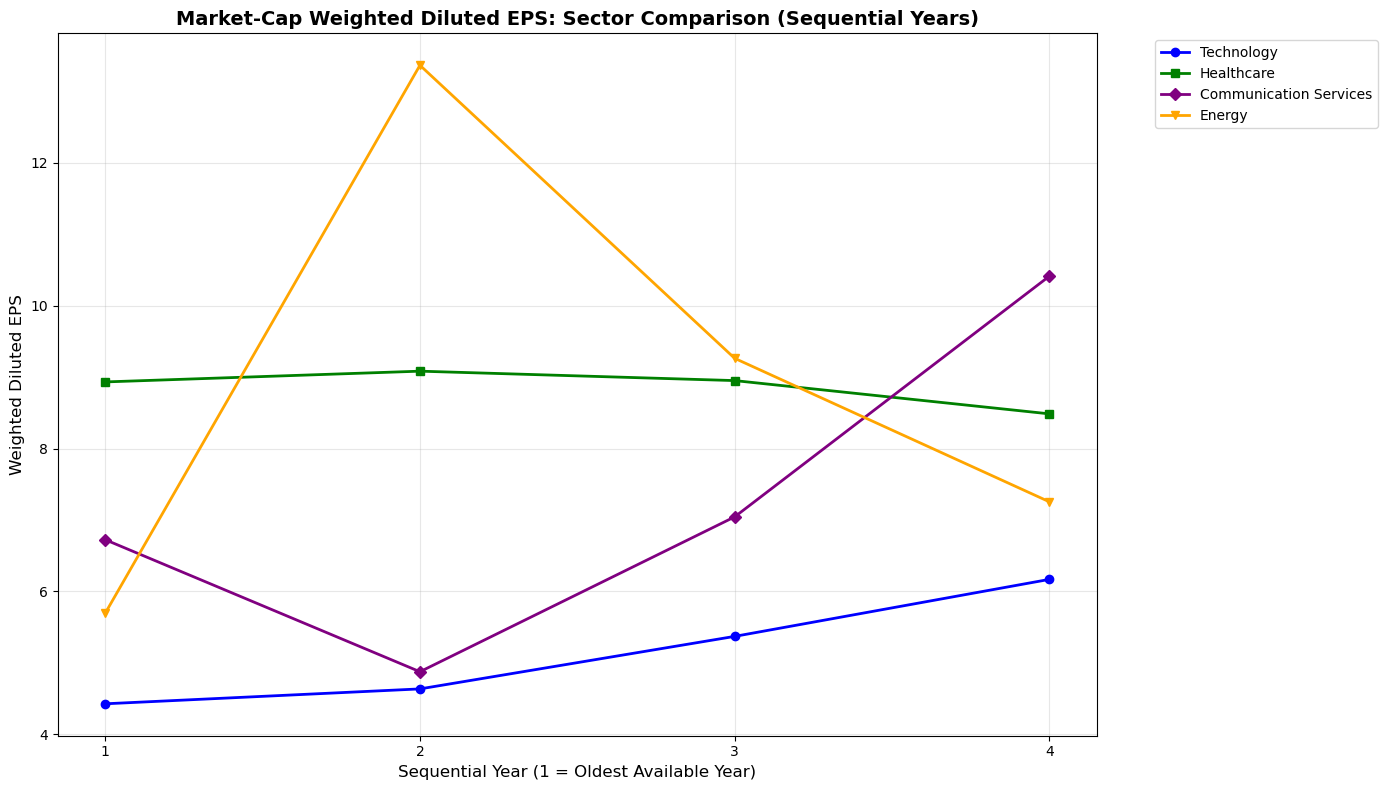

In [105]:
# Plot all sectors comparison with sequential years
plt.figure(figsize=(14, 8))

# Define colors and markers for each sector
sectors_seq = {
    'Technology': (tech_eps_weighted_seq, 'blue', 'o', 'Technology'),
    'Healthcare': (healthcare_eps_weighted_seq, 'green', 's', 'Healthcare'),
    'Communications': (communications_eps_weighted_seq, 'purple', 'D', 'Communication Services'),
    'Energy': (energy_eps_weighted_seq, 'orange', 'v', 'Energy'),
}

# Plot each sector
for sector_name, (sector_data, color, marker, label) in sectors_seq.items():
    if sector_data is not None and len(sector_data) > 0:
        plt.plot(sector_data.index, sector_data.values, 
                 marker=marker, linewidth=2, markersize=6, 
                 color=color, label=label)

plt.title('Market-Cap Weighted Diluted EPS: Sector Comparison (Sequential Years)', fontsize=14, fontweight='bold')
plt.xlabel('Sequential Year (1 = Oldest Available Year)', fontsize=12)
plt.ylabel('Weighted Diluted EPS', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Set x-axis to show sequential years
all_seq_years = set()
for sector_data, _, _, _ in sectors_seq.values():
    if sector_data is not None:
        all_seq_years.update(sector_data.index)
if all_seq_years:
    plt.xticks(sorted(all_seq_years))

plt.tight_layout()
plt.show()

In [111]:
combined_df 

,Ticker,Company,Sector,Industry,Market Cap,Basic EPS,Free Cash Flow,P/E Ratio,Share Price
0,NVDA,NVIDIA Corporation,Technology,Semiconductors,4460857262080,0.391,8.132000e+09,62.506454,24.440023
1,META,"Meta Platforms, Inc.",Communication Services,Internet Content & Information,1800991932416,24.610,5.407200e+10,23.736106,584.145569
2,GOOGL,Alphabet Inc.,Communication Services,Internet Content & Information,3066071089152,5.694,6.701200e+10,25.265149,143.859756
3,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,3847852654592,9.700,6.514900e+10,25.779930,250.065323
4,AAPL,Apple Inc.,Technology,Consumer Electronics,3899609055232,5.670,9.295300e+10,24.431184,138.524811
